In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage

In [2]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

# Check dataset

In [3]:
X_vec = np.stack([gray2rgb(iimg)
                 for iimg in faces.data.reshape((-1, 64, 64))],0)
y_vec = faces.target.astype(np.uint8)

(-0.5, 1279.5, 1279.5, -0.5)

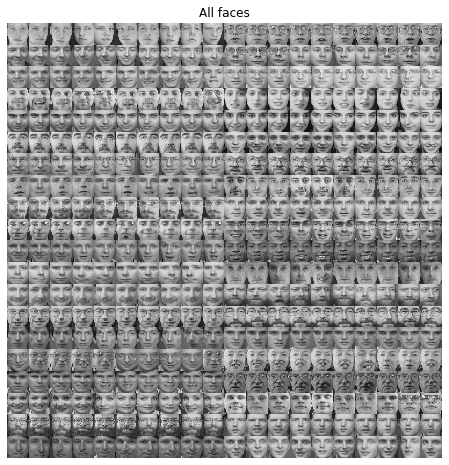

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(montage(X_vec[:, :, :, 0]), cmap="gray", interpolation="none")
ax.set_title("All faces")
ax.axis("off")

In [5]:
def show_face(index):
    plt.imshow(X_vec[index], cmap="gray")
    plt.title("{} index face".format(index))
    plt.axis("off")

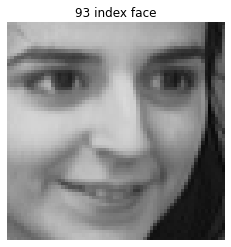

In [6]:
show_face(93)

# Train model

In [7]:
def predict_proba(image):
    return session.run(model_predict, feed_dict = {preprocessed_image: image})

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, train_size=0.7)

In [9]:
X_train

array([[[[0.553719  , 0.553719  , 0.553719  ],
         [0.59917355, 0.59917355, 0.59917355],
         [0.6198347 , 0.6198347 , 0.6198347 ],
         ...,
         [0.5082645 , 0.5082645 , 0.5082645 ],
         [0.5082645 , 0.5082645 , 0.5082645 ],
         [0.5082645 , 0.5082645 , 0.5082645 ]],

        [[0.553719  , 0.553719  , 0.553719  ],
         [0.59504133, 0.59504133, 0.59504133],
         [0.61570245, 0.61570245, 0.61570245],
         ...,
         [0.49586776, 0.49586776, 0.49586776],
         [0.5041322 , 0.5041322 , 0.5041322 ],
         [0.49586776, 0.49586776, 0.49586776]],

        [[0.55785125, 0.55785125, 0.55785125],
         [0.59090906, 0.59090906, 0.59090906],
         [0.61157024, 0.61157024, 0.61157024],
         ...,
         [0.49173555, 0.49173555, 0.49173555],
         [0.49586776, 0.49586776, 0.49586776],
         [0.4876033 , 0.4876033 , 0.4876033 ]],

        ...,

        [[0.37603307, 0.37603307, 0.37603307],
         [0.38016528, 0.38016528, 0.38016528]

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func
    
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)
    
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])

flatten_step= PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    ("Make Gray", makegray_step),
    ("Flatten Image", flatten_step),
    ("MLP", MLPClassifier(
    activation="relu",
    alpha=1e-7,
    epsilon=1e-6,
    hidden_layer_sizes = (800, 120),
    random_state=2))
])

In [26]:
simple_pipeline.fit(X_train, y_train)

C:\Users\hjhhi\anaconda3\envs\XAI\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x0000024B02037978>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x0000024B020379B0>),
                ('MLP',
                 MLPClassifier(alpha=1e-07, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               random_state=2))])

In [27]:
pipe_pred_test = simple_pipeline.predict(X_test)
pipe_pred_prop = simple_pipeline.predict_proba(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4
           2       0.67      1.00      0.80         2
           3       0.33      1.00      0.50         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         5
           6       1.00      0.83      0.91         6
           7       1.00      0.75      0.86         4
           8       0.67      1.00      0.80         2
           9       1.00      0.75      0.86         4
          10       1.00      1.00      1.00         6
          11       1.00      1.00      1.00         2
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         4
          15       1.00      1.00      1.00         1
          16       0.67      1.00      0.80         4
          17       0.67    

In [34]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

segmenter = SegmentationAlgorithm("slic", n_segments=100, compactness=1, sigma=1)

In [54]:
%%time

olivetti_test_index=16

exp = explainer.explain_instance(X_test[olivetti_test_index],
                                classifier_fn = simple_pipeline.predict_proba,
                                top_labels=6,
                                num_samples=1000,
                                segmentation_fn=segmenter)

C:\Users\hjhhi\anaconda3\envs\XAI\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 705 ms


Text(0.5, 1.0, 'Show mask only')

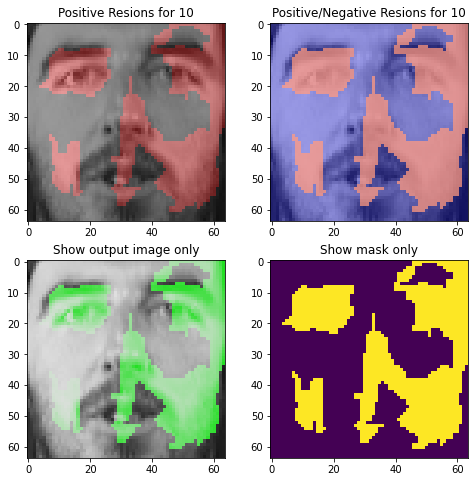

In [55]:
from skimage.color import label2rgb

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 8))

temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                   positive_only=True,
                                   num_features=8,
                                   hide_rest=False)
ax1.imshow(label2rgb(mask, temp, bg_label=0),interpolation="nearest")
ax1.set_title("Positive Resions for {}".format(y_test[olivetti_test_index]))

temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                   positive_only=False,
                                   num_features=8,
                                   hide_rest=False)
ax2.imshow(label2rgb(4 - mask, temp, bg_label=0), interpolation="nearest")
ax2.set_title("Positive/Negative Resions for {}".format(y_test[olivetti_test_index]))

ax3.imshow(temp, interpolation="nearest")
ax3.set_title("Show output image only")

ax4.imshow(mask, interpolation="nearest")
ax4.set_title("Show mask only")